# KE5105 - Building Electrical Consumption Forecasting

# Modelling 7 - Preliminary model

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/Documents/KE5105/ETL',
 '/home/tkokkeng/python/python367/tsfvenv/lib',
 '/home/tkokkeng/Documents/KE5105/ETL/source',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard

Using TensorFlow backend.


## Load data for building AS5

In [4]:
as5 = mu.load_data_by_bldg(['AS5'], 'processed')

In [5]:
as5[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         46164 non-null float64
PWMEXTAS4ExBldg                   46165 non-null float64
PWMAS4LanguageCenter              46165 non-null float64
PWMCANTEEN                        46164 non-null float64
PWMStreetLight                    46164 non-null float64
BTUAS5                            46175 non-null float64
PWMMainIC_30min_avg               46117 non-null float64
PWMEXTAS4ExBldg_30min_avg         46118 non-null float64
PWMAS4LanguageCenter_30min_avg    46118 non-null float64
PWMCANTEEN_30min_avg              46117 non-null float64
PWMStreetLight_30min_avg          46117 non-null float64
BTUAS5_30min_avg                  46129 non-null float64
PWM_sumadd                        46117 non-null float64
PWM_sumsubtract                   46117 non-null float64
PWM_30min_avg                     46117 non-null float64
B

## Split the data into train and test set

In [6]:
as5_train_df = as5[0][1].loc['2015-06-12 08:00:00':'2017-03-31 23:30:00', :]

In [7]:
as5_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     29985 non-null float64
B

In [8]:
as5_test_df = as5[0][1].loc['2018-01-01 00:00:00':, :]

In [9]:
as5_test_df.index.max()

Timestamp('2018-12-31 23:30:00')

In [10]:
as5_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2018-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         16145 non-null float64
PWMEXTAS4ExBldg                   16145 non-null float64
PWMAS4LanguageCenter              16145 non-null float64
PWMCANTEEN                        16145 non-null float64
PWMStreetLight                    16145 non-null float64
BTUAS5                            16144 non-null float64
PWMMainIC_30min_avg               16132 non-null float64
PWMEXTAS4ExBldg_30min_avg         16132 non-null float64
PWMAS4LanguageCenter_30min_avg    16132 non-null float64
PWMCANTEEN_30min_avg              16132 non-null float64
PWMStreetLight_30min_avg          16132 non-null float64
BTUAS5_30min_avg                  16130 non-null float64
PWM_sumadd                        16132 non-null float64
PWM_sumsubtract                   16132 non-null float64
PWM_30min_avg                     16132 non-null float64
B

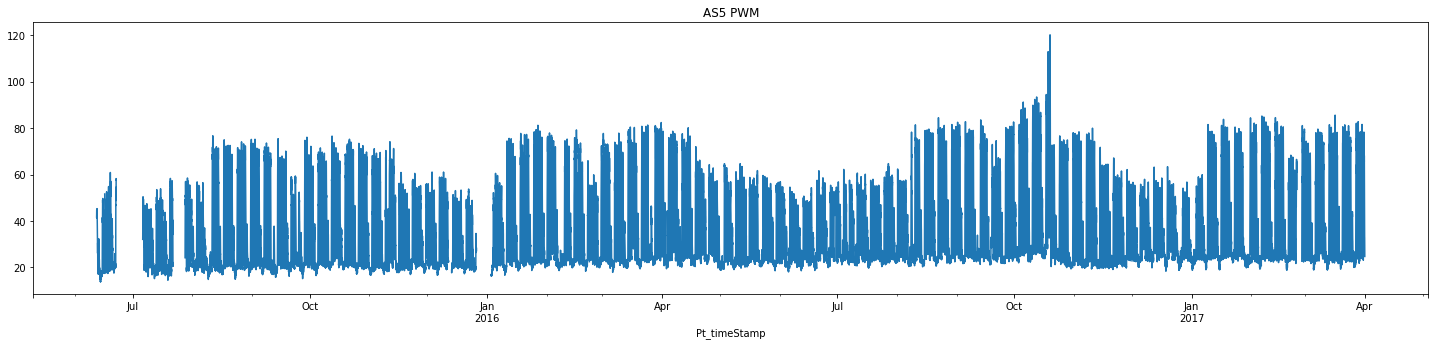

In [11]:
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [12]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## Normalise the training data

* Convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [13]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [14]:
as5_train_data = my_pipeline.fit_transform(as5_train_df)
as5_train_data

array([[ 0.26254935,  0.56924225],
       [ 0.26724948,  0.53427896],
       [ 0.28031585,  0.53353241],
       ...,
       [ 0.12897161,  0.03222595],
       [ 0.10312089,  0.00348389],
       [-1.        , -1.        ]])

Text(0.5, 1.0, 'Normalised PWM Training Data')

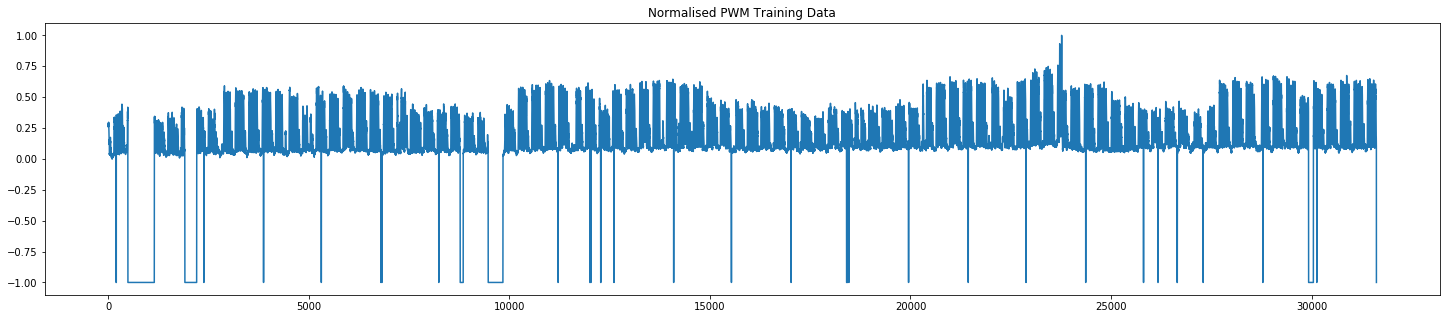

In [15]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

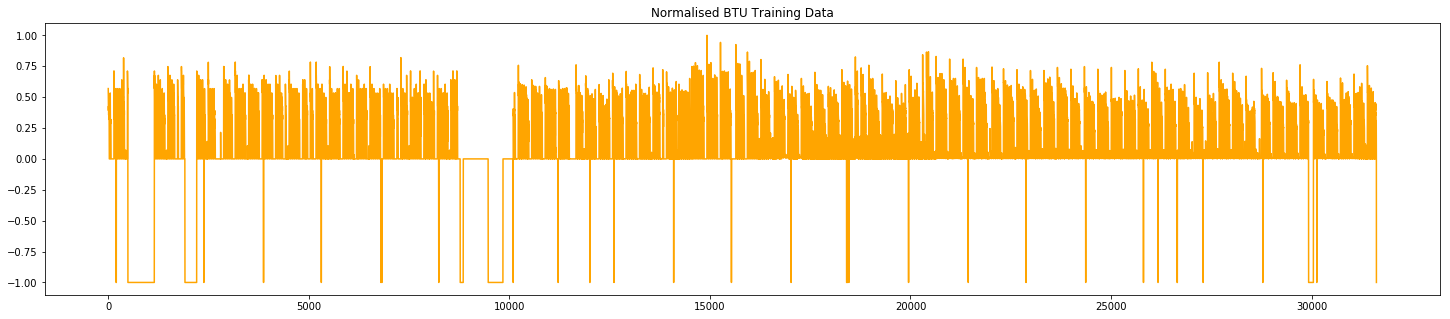

In [16]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

## Split a validation set out from the train set

In [17]:
as5_train_split = as5_train_data[:20000]
as5_val_split = as5_train_data[20000:]

In [18]:
print('train split = %s\nvalidation split = %s' % (as5_train_split.shape, as5_val_split.shape))

train split = (20000, 2)
validation split = (11616, 2)


## 4x128 GRU, 2x32 Dense Model with Dropout (0.1) and No Recurrent Dropout

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [22]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [34]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0100-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0100.h5'))
model.summary()

In [43]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50


Epoch 1/50


 - 86s - loss: 0.0171 - mean_absolute_percentage_error: 12.0224 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 9.9647


Epoch 2/50


 - 85s - loss: 0.0168 - mean_absolute_percentage_error: 11.6243 - val_loss: 0.0344 - val_mean_absolute_percentage_error: 15.3454


Epoch 3/50


 - 87s - loss: 0.0167 - mean_absolute_percentage_error: 11.6560 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 13.5094


Epoch 4/50


 - 86s - loss: 0.0166 - mean_absolute_percentage_error: 11.5926 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 11.5723


Epoch 5/50


 - 85s - loss: 0.0168 - mean_absolute_percentage_error: 11.5655 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 10.3368


Epoch 6/50


 - 85s - loss: 0.0164 - mean_absolute_percentage_error: 11.4245 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 15.7287


Epoch 7/50


 - 86s - loss: 0.0166 - mean_absolute_percentage_error: 11.5572 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 9.9357


Epoch 8/50


 - 85s - loss: 0.0165 - mean_absolute_percentage_error: 11.6128 - val_loss: 0.0306 - val_mean_absolute_percentage_error: 14.1639


Epoch 9/50


 - 85s - loss: 0.0162 - mean_absolute_percentage_error: 11.2618 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 12.4204


Epoch 10/50


 - 84s - loss: 0.0163 - mean_absolute_percentage_error: 11.4064 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 15.9102


Epoch 11/50


 - 84s - loss: 0.0163 - mean_absolute_percentage_error: 11.5465 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 8.8550


Epoch 12/50


 - 85s - loss: 0.0162 - mean_absolute_percentage_error: 11.3691 - val_loss: 0.0297 - val_mean_absolute_percentage_error: 11.2001


Epoch 13/50


 - 84s - loss: 0.0163 - mean_absolute_percentage_error: 11.4084 - val_loss: 0.0325 - val_mean_absolute_percentage_error: 13.9207


Epoch 14/50


 - 84s - loss: 0.0162 - mean_absolute_percentage_error: 11.3452 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 9.7970


Epoch 15/50


 - 84s - loss: 0.0163 - mean_absolute_percentage_error: 11.1072 - val_loss: 0.0338 - val_mean_absolute_percentage_error: 13.8119


Epoch 16/50


 - 84s - loss: 0.0161 - mean_absolute_percentage_error: 11.2694 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 12.7980


Epoch 17/50


 - 84s - loss: 0.0160 - mean_absolute_percentage_error: 11.1229 - val_loss: 0.0327 - val_mean_absolute_percentage_error: 15.7223


Epoch 18/50


 - 84s - loss: 0.0158 - mean_absolute_percentage_error: 10.8383 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 11.4082


Epoch 19/50


 - 86s - loss: 0.0160 - mean_absolute_percentage_error: 11.1387 - val_loss: 0.0311 - val_mean_absolute_percentage_error: 14.7594


Epoch 20/50


 - 85s - loss: 0.0159 - mean_absolute_percentage_error: 10.9104 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 15.7994


Epoch 21/50


 - 86s - loss: 0.0159 - mean_absolute_percentage_error: 10.9630 - val_loss: 0.0337 - val_mean_absolute_percentage_error: 16.4207


Epoch 22/50


 - 87s - loss: 0.0158 - mean_absolute_percentage_error: 10.8370 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 14.6143


Epoch 23/50


 - 86s - loss: 0.0157 - mean_absolute_percentage_error: 10.8283 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 9.9764


Epoch 24/50


 - 85s - loss: 0.0156 - mean_absolute_percentage_error: 10.8772 - val_loss: 0.0360 - val_mean_absolute_percentage_error: 16.3037


Epoch 25/50


 - 85s - loss: 0.0156 - mean_absolute_percentage_error: 10.7708 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 12.9687


Epoch 26/50


 - 85s - loss: 0.0155 - mean_absolute_percentage_error: 10.7222 - val_loss: 0.0304 - val_mean_absolute_percentage_error: 12.5671


Epoch 27/50


 - 85s - loss: 0.0154 - mean_absolute_percentage_error: 10.8116 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 10.7769


Epoch 28/50


 - 86s - loss: 0.0155 - mean_absolute_percentage_error: 10.8546 - val_loss: 0.0224 - val_mean_absolute_percentage_error: 11.1032


Epoch 29/50


 - 86s - loss: 0.0154 - mean_absolute_percentage_error: 10.6270 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 10.2243


Epoch 30/50


 - 86s - loss: 0.0153 - mean_absolute_percentage_error: 10.6831 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 11.6795


Epoch 31/50


 - 85s - loss: 0.0156 - mean_absolute_percentage_error: 10.7268 - val_loss: 0.0305 - val_mean_absolute_percentage_error: 13.2367


Epoch 32/50


 - 84s - loss: 0.0154 - mean_absolute_percentage_error: 10.9631 - val_loss: 0.0310 - val_mean_absolute_percentage_error: 14.3728


Epoch 33/50


 - 84s - loss: 0.0153 - mean_absolute_percentage_error: 10.9301 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 10.8011


Epoch 34/50


 - 84s - loss: 0.0149 - mean_absolute_percentage_error: 10.4653 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 10.2863


Epoch 35/50


 - 86s - loss: 0.0153 - mean_absolute_percentage_error: 10.5842 - val_loss: 0.0250 - val_mean_absolute_percentage_error: 12.4111


Epoch 36/50


 - 86s - loss: 0.0149 - mean_absolute_percentage_error: 10.3829 - val_loss: 0.0344 - val_mean_absolute_percentage_error: 16.5277


Epoch 37/50


 - 86s - loss: 0.0150 - mean_absolute_percentage_error: 10.5014 - val_loss: 0.0318 - val_mean_absolute_percentage_error: 15.3042


Epoch 38/50


 - 85s - loss: 0.0149 - mean_absolute_percentage_error: 10.3825 - val_loss: 0.0250 - val_mean_absolute_percentage_error: 11.7497


Epoch 39/50


 - 85s - loss: 0.0150 - mean_absolute_percentage_error: 10.4764 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 15.9315


Epoch 40/50


 - 84s - loss: 0.0149 - mean_absolute_percentage_error: 10.4563 - val_loss: 0.0314 - val_mean_absolute_percentage_error: 13.7804


Epoch 41/50


 - 85s - loss: 0.0149 - mean_absolute_percentage_error: 10.4704 - val_loss: 0.0250 - val_mean_absolute_percentage_error: 10.2311


Epoch 42/50


 - 85s - loss: 0.0148 - mean_absolute_percentage_error: 10.3275 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 13.1201


Epoch 43/50


 - 85s - loss: 0.0148 - mean_absolute_percentage_error: 10.2230 - val_loss: 0.0351 - val_mean_absolute_percentage_error: 13.8458


Epoch 44/50


 - 85s - loss: 0.0147 - mean_absolute_percentage_error: 10.2862 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 11.6548


Epoch 45/50


 - 85s - loss: 0.0147 - mean_absolute_percentage_error: 10.2231 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 11.8438


Epoch 46/50


 - 85s - loss: 0.0147 - mean_absolute_percentage_error: 10.1059 - val_loss: 0.0351 - val_mean_absolute_percentage_error: 15.7759


Epoch 47/50


 - 86s - loss: 0.0146 - mean_absolute_percentage_error: 10.1955 - val_loss: 0.0314 - val_mean_absolute_percentage_error: 16.0121


Epoch 48/50


 - 89s - loss: 0.0147 - mean_absolute_percentage_error: 10.2089 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 10.0641


Epoch 49/50


 - 85s - loss: 0.0145 - mean_absolute_percentage_error: 10.3086 - val_loss: 0.0318 - val_mean_absolute_percentage_error: 12.2293


Epoch 50/50


 - 85s - loss: 0.0144 - mean_absolute_percentage_error: 10.0015 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 11.7964



Training Duration = 1:10:59.656404


In [44]:
# histories = [] # for first training session
histories.append(history.history)

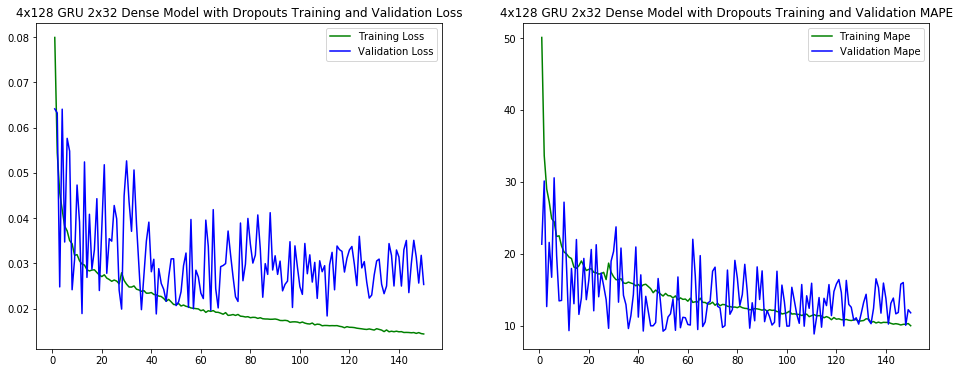

In [45]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [46]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss[-10:]) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.534367
Validation MAE = 2.505476


In [47]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [48]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

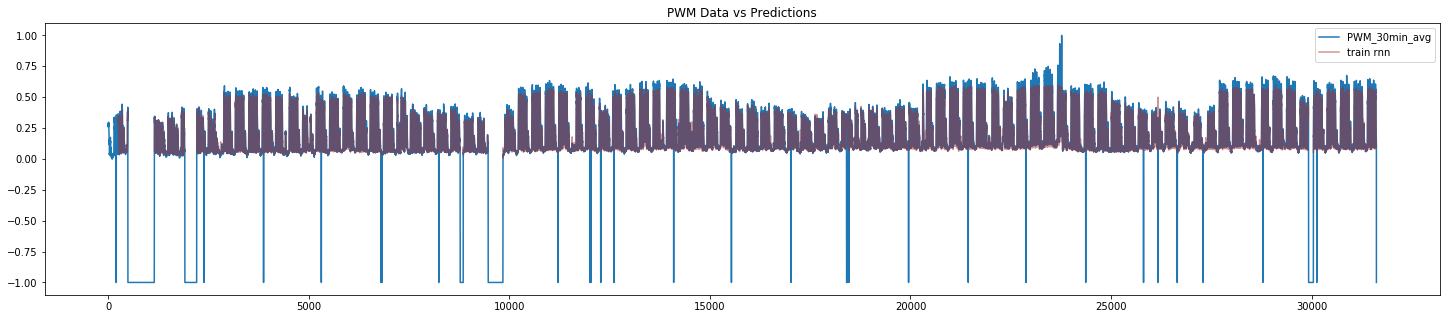

In [49]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

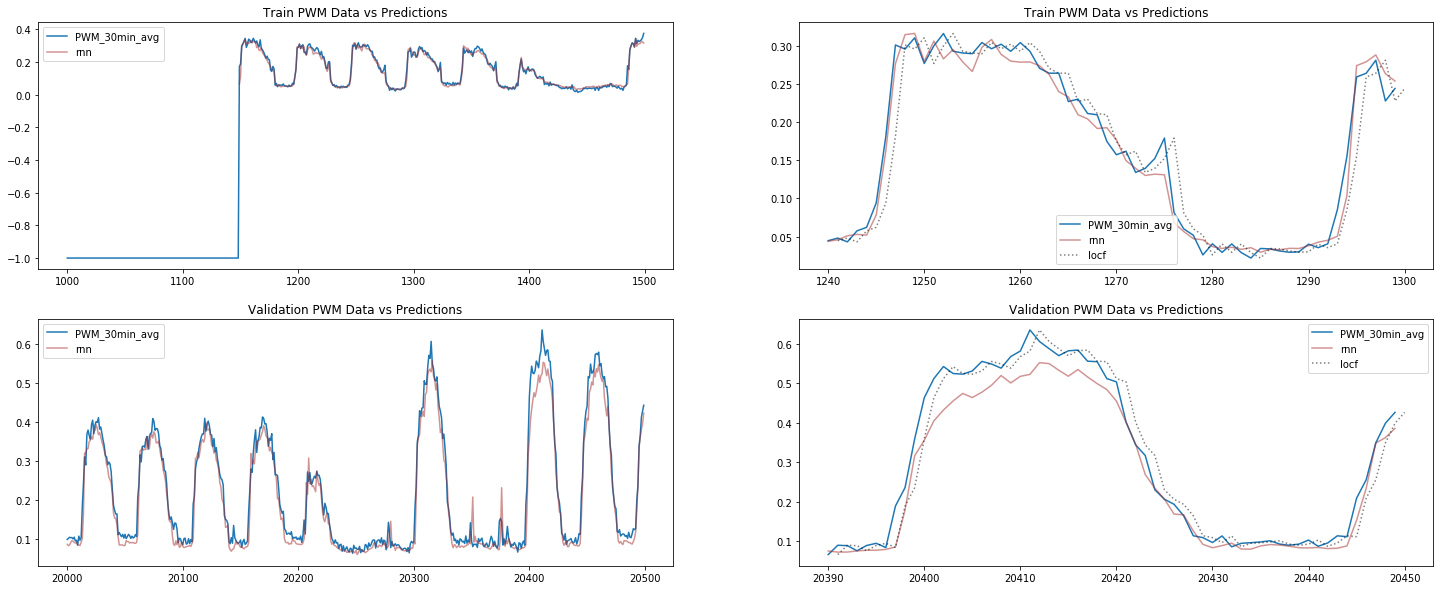

In [50]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [51]:
model.save('base-4x128gru-2x32dense-dropout0100.h5')

In [52]:
with open('base-4x128gru-2x32dense-dropout0100-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Dropout (0.1) and Recurrent Dropout (0.2)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.2, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [20]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [21]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0102-epch50-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0102-epch50.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [43]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50

 - 91s - loss: 0.0163 - mean_absolute_percentage_error: 10.9840 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 11.3677


Epoch 2/50


 - 92s - loss: 0.0166 - mean_absolute_percentage_error: 11.1946 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 13.9685


Epoch 3/50


 - 91s - loss: 0.0169 - mean_absolute_percentage_error: 11.3835 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 11.0788


Epoch 4/50


 - 91s - loss: 0.0169 - mean_absolute_percentage_error: 11.3207 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 12.0514


Epoch 5/50


 - 92s - loss: 0.0168 - mean_absolute_percentage_error: 11.3684 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 11.6396


Epoch 6/50


 - 91s - loss: 0.0170 - mean_absolute_percentage_error: 11.2922 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 11.5798


Epoch 7/50


 - 91s - loss: 0.0167 - mean_absolute_percentage_error: 11.3904 - val_loss: 0.0343 - val_mean_absolute_percentage_error: 16.8148


Epoch 8/50


 - 92s - loss: 0.0167 - mean_absolute_percentage_error: 11.2843 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 13.7214


Epoch 9/50


 - 92s - loss: 0.0165 - mean_absolute_percentage_error: 11.2352 - val_loss: 0.0355 - val_mean_absolute_percentage_error: 14.9849


Epoch 10/50


 - 92s - loss: 0.0165 - mean_absolute_percentage_error: 11.1700 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 12.7072


Epoch 11/50


 - 91s - loss: 0.0167 - mean_absolute_percentage_error: 11.3324 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 9.9956


Epoch 12/50


 - 92s - loss: 0.0166 - mean_absolute_percentage_error: 11.1086 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 14.3978


Epoch 13/50


 - 92s - loss: 0.0166 - mean_absolute_percentage_error: 11.2458 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 12.7129


Epoch 14/50


 - 92s - loss: 0.0167 - mean_absolute_percentage_error: 11.3283 - val_loss: 0.0367 - val_mean_absolute_percentage_error: 15.1194


Epoch 15/50


 - 92s - loss: 0.0166 - mean_absolute_percentage_error: 11.1945 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 11.6893


Epoch 16/50


 - 92s - loss: 0.0166 - mean_absolute_percentage_error: 11.3052 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 13.2164


Epoch 17/50


 - 92s - loss: 0.0165 - mean_absolute_percentage_error: 11.2098 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 11.7795


Epoch 18/50


 - 92s - loss: 0.0164 - mean_absolute_percentage_error: 11.1276 - val_loss: 0.0379 - val_mean_absolute_percentage_error: 15.9841


Epoch 19/50


 - 91s - loss: 0.0165 - mean_absolute_percentage_error: 11.0317 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 9.8110


Epoch 20/50


 - 91s - loss: 0.0165 - mean_absolute_percentage_error: 11.1411 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 9.8801


Epoch 21/50


 - 91s - loss: 0.0164 - mean_absolute_percentage_error: 11.0513 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 10.5305


Epoch 22/50


 - 91s - loss: 0.0162 - mean_absolute_percentage_error: 11.0094 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 11.6019


Epoch 23/50


 - 92s - loss: 0.0166 - mean_absolute_percentage_error: 11.1456 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 12.1350


Epoch 24/50


 - 91s - loss: 0.0164 - mean_absolute_percentage_error: 11.0249 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 11.5897


Epoch 25/50


 - 90s - loss: 0.0163 - mean_absolute_percentage_error: 11.0044 - val_loss: 0.0347 - val_mean_absolute_percentage_error: 15.9830


Epoch 26/50


 - 91s - loss: 0.0162 - mean_absolute_percentage_error: 11.1297 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 11.5817


Epoch 27/50


 - 91s - loss: 0.0165 - mean_absolute_percentage_error: 11.1866 - val_loss: 0.0287 - val_mean_absolute_percentage_error: 14.6732


Epoch 28/50


 - 91s - loss: 0.0162 - mean_absolute_percentage_error: 11.0003 - val_loss: 0.0327 - val_mean_absolute_percentage_error: 14.6257


Epoch 29/50


 - 94s - loss: 0.0163 - mean_absolute_percentage_error: 11.0808 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 12.4164


Epoch 30/50


 - 92s - loss: 0.0162 - mean_absolute_percentage_error: 10.9304 - val_loss: 0.0369 - val_mean_absolute_percentage_error: 16.6455


Epoch 31/50


 - 92s - loss: 0.0162 - mean_absolute_percentage_error: 10.9206 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 11.6015


Epoch 32/50


 - 91s - loss: 0.0162 - mean_absolute_percentage_error: 10.8892 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 15.1414


Epoch 33/50


 - 90s - loss: 0.0160 - mean_absolute_percentage_error: 10.8003 - val_loss: 0.0335 - val_mean_absolute_percentage_error: 17.1724


Epoch 34/50


 - 90s - loss: 0.0162 - mean_absolute_percentage_error: 10.8903 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 13.2344


Epoch 35/50


 - 90s - loss: 0.0162 - mean_absolute_percentage_error: 10.9156 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 10.4738


Epoch 36/50


 - 91s - loss: 0.0162 - mean_absolute_percentage_error: 11.0684 - val_loss: 0.0231 - val_mean_absolute_percentage_error: 10.5141


Epoch 37/50


 - 90s - loss: 0.0160 - mean_absolute_percentage_error: 10.8931 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 10.7290


Epoch 38/50


 - 90s - loss: 0.0159 - mean_absolute_percentage_error: 10.6636 - val_loss: 0.0310 - val_mean_absolute_percentage_error: 13.2502


Epoch 39/50


 - 90s - loss: 0.0160 - mean_absolute_percentage_error: 10.6485 - val_loss: 0.0335 - val_mean_absolute_percentage_error: 14.8262


Epoch 40/50


 - 91s - loss: 0.0156 - mean_absolute_percentage_error: 10.6715 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 13.3752


Epoch 41/50


 - 91s - loss: 0.0162 - mean_absolute_percentage_error: 11.0826 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 12.2145


Epoch 42/50


 - 91s - loss: 0.0156 - mean_absolute_percentage_error: 10.5071 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 10.9936


Epoch 43/50


 - 92s - loss: 0.0155 - mean_absolute_percentage_error: 10.4958 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 12.2963


Epoch 44/50


 - 93s - loss: 0.0155 - mean_absolute_percentage_error: 10.4630 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 10.6791


Epoch 45/50


 - 91s - loss: 0.0156 - mean_absolute_percentage_error: 10.5832 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 11.9482


Epoch 46/50


 - 92s - loss: 0.0156 - mean_absolute_percentage_error: 10.5515 - val_loss: 0.0315 - val_mean_absolute_percentage_error: 12.2829


Epoch 47/50


 - 95s - loss: 0.0156 - mean_absolute_percentage_error: 10.6616 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 16.3970


Epoch 48/50


 - 95s - loss: 0.0156 - mean_absolute_percentage_error: 10.6457 - val_loss: 0.0306 - val_mean_absolute_percentage_error: 13.3019


Epoch 49/50


 - 96s - loss: 0.0155 - mean_absolute_percentage_error: 10.6110 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 10.0052


Epoch 50/50


 - 94s - loss: 0.0155 - mean_absolute_percentage_error: 10.4879 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 13.2090



Training Duration = 1:16:19.895959


In [44]:
# histories = []  # for first training session
histories.append(history.history)

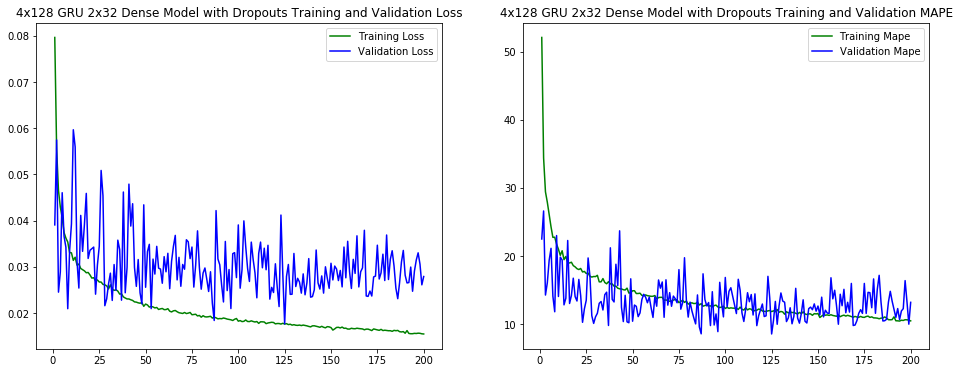

In [45]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [46]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss[-10:]) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.644406
Validation MAE = 2.628233


In [47]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [48]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

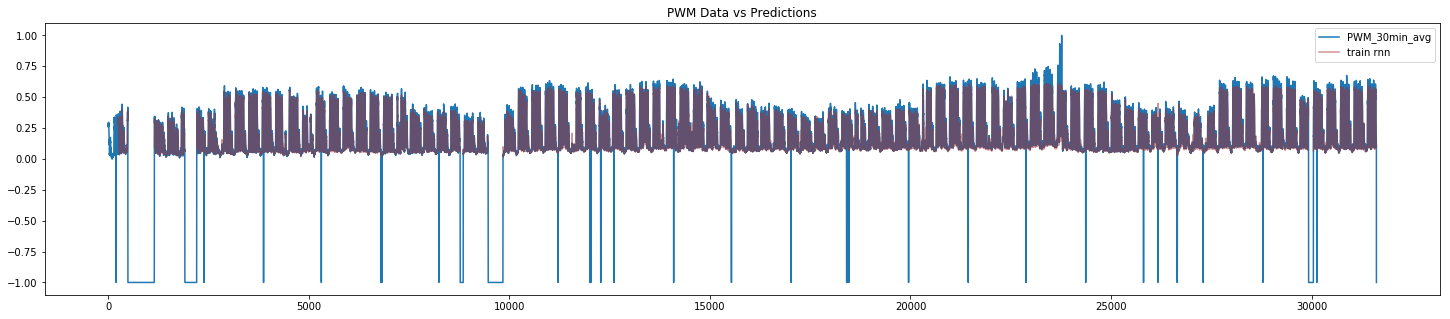

In [49]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

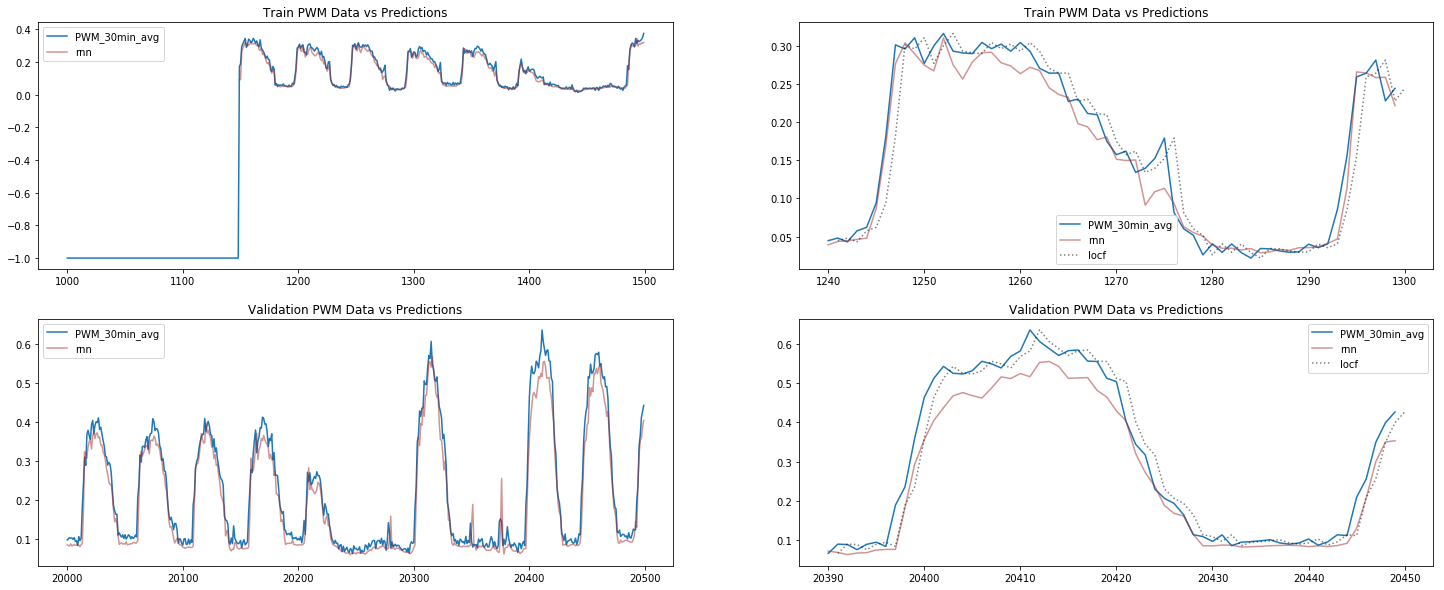

In [50]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [51]:
model.save('base-4x128gru-2x32dense-dropout0102-epch200.h5')

In [52]:
with open('base-4x128gru-2x32dense-dropout0102-epch200-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Dropout (0.1) and Recurrent Dropout (0.4)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.4, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.4, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.4, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.4, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [20]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [21]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0104-epch50-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0104-epch50.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [54]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50

 - 94s - loss: 0.0166 - mean_absolute_percentage_error: 11.0377 - val_loss: 0.0342 - val_mean_absolute_percentage_error: 17.3515


Epoch 2/50


 - 94s - loss: 0.0169 - mean_absolute_percentage_error: 11.3671 - val_loss: 0.0315 - val_mean_absolute_percentage_error: 14.3414


Epoch 3/50


 - 94s - loss: 0.0167 - mean_absolute_percentage_error: 11.3488 - val_loss: 0.0324 - val_mean_absolute_percentage_error: 13.9184


Epoch 4/50


 - 94s - loss: 0.0169 - mean_absolute_percentage_error: 11.3482 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 12.3876


Epoch 5/50


 - 94s - loss: 0.0169 - mean_absolute_percentage_error: 11.3245 - val_loss: 0.0345 - val_mean_absolute_percentage_error: 15.3350


Epoch 6/50


 - 94s - loss: 0.0166 - mean_absolute_percentage_error: 11.1723 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 13.8063


Epoch 7/50


 - 94s - loss: 0.0160 - mean_absolute_percentage_error: 10.8153 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 14.1514


Epoch 8/50


 - 95s - loss: 0.0166 - mean_absolute_percentage_error: 11.1650 - val_loss: 0.0305 - val_mean_absolute_percentage_error: 13.1860


Epoch 9/50


 - 95s - loss: 0.0167 - mean_absolute_percentage_error: 11.3652 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 11.5596


Epoch 10/50


 - 94s - loss: 0.0169 - mean_absolute_percentage_error: 11.4219 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 12.6999


Epoch 11/50


 - 95s - loss: 0.0166 - mean_absolute_percentage_error: 11.2404 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 9.9477


Epoch 12/50


 - 94s - loss: 0.0165 - mean_absolute_percentage_error: 11.1846 - val_loss: 0.0212 - val_mean_absolute_percentage_error: 10.0737


Epoch 13/50


 - 95s - loss: 0.0167 - mean_absolute_percentage_error: 11.4266 - val_loss: 0.0326 - val_mean_absolute_percentage_error: 13.4444


Epoch 14/50


 - 94s - loss: 0.0167 - mean_absolute_percentage_error: 11.2656 - val_loss: 0.0322 - val_mean_absolute_percentage_error: 12.9358


Epoch 15/50


 - 94s - loss: 0.0166 - mean_absolute_percentage_error: 11.1651 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 12.0227


Epoch 16/50


 - 95s - loss: 0.0167 - mean_absolute_percentage_error: 11.2737 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 11.5513


Epoch 17/50


 - 94s - loss: 0.0164 - mean_absolute_percentage_error: 11.0357 - val_loss: 0.0301 - val_mean_absolute_percentage_error: 13.8616


Epoch 18/50


 - 94s - loss: 0.0162 - mean_absolute_percentage_error: 10.9306 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 11.8154


Epoch 19/50


 - 94s - loss: 0.0167 - mean_absolute_percentage_error: 11.3033 - val_loss: 0.0294 - val_mean_absolute_percentage_error: 12.6350


Epoch 20/50


 - 95s - loss: 0.0165 - mean_absolute_percentage_error: 11.1298 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 11.7044


Epoch 21/50


 - 94s - loss: 0.0166 - mean_absolute_percentage_error: 11.2442 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 14.4928


Epoch 22/50


 - 93s - loss: 0.0165 - mean_absolute_percentage_error: 11.2675 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 11.1689


Epoch 23/50


 - 93s - loss: 0.0160 - mean_absolute_percentage_error: 10.8263 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 11.0524


Epoch 24/50


 - 92s - loss: 0.0167 - mean_absolute_percentage_error: 11.1908 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 12.4603


Epoch 25/50


 - 92s - loss: 0.0166 - mean_absolute_percentage_error: 11.1703 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 15.5833


Epoch 26/50


 - 92s - loss: 0.0160 - mean_absolute_percentage_error: 10.7211 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 14.0125


Epoch 27/50


 - 92s - loss: 0.0165 - mean_absolute_percentage_error: 11.0516 - val_loss: 0.0297 - val_mean_absolute_percentage_error: 12.2031


Epoch 28/50


 - 92s - loss: 0.0165 - mean_absolute_percentage_error: 11.1158 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 13.6833


Epoch 29/50


 - 92s - loss: 0.0164 - mean_absolute_percentage_error: 10.9641 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 12.7422


Epoch 30/50


 - 92s - loss: 0.0160 - mean_absolute_percentage_error: 10.7106 - val_loss: 0.0306 - val_mean_absolute_percentage_error: 16.2079


Epoch 31/50


 - 92s - loss: 0.0167 - mean_absolute_percentage_error: 11.3624 - val_loss: 0.0249 - val_mean_absolute_percentage_error: 11.0825


Epoch 32/50


 - 92s - loss: 0.0164 - mean_absolute_percentage_error: 11.0669 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 11.8221


Epoch 33/50


 - 92s - loss: 0.0165 - mean_absolute_percentage_error: 10.9726 - val_loss: 0.0296 - val_mean_absolute_percentage_error: 13.8635


Epoch 34/50


 - 92s - loss: 0.0165 - mean_absolute_percentage_error: 11.1597 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 12.1940


Epoch 35/50


 - 92s - loss: 0.0163 - mean_absolute_percentage_error: 10.9973 - val_loss: 0.0312 - val_mean_absolute_percentage_error: 14.7696


Epoch 36/50


 - 92s - loss: 0.0164 - mean_absolute_percentage_error: 11.1158 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 12.7313


Epoch 37/50


 - 92s - loss: 0.0163 - mean_absolute_percentage_error: 10.9927 - val_loss: 0.0333 - val_mean_absolute_percentage_error: 15.8361


Epoch 38/50


 - 92s - loss: 0.0164 - mean_absolute_percentage_error: 11.0931 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 13.6566


Epoch 39/50


 - 92s - loss: 0.0163 - mean_absolute_percentage_error: 11.0935 - val_loss: 0.0294 - val_mean_absolute_percentage_error: 11.4746


Epoch 40/50


 - 92s - loss: 0.0164 - mean_absolute_percentage_error: 10.8989 - val_loss: 0.0342 - val_mean_absolute_percentage_error: 13.4913


Epoch 41/50


 - 92s - loss: 0.0163 - mean_absolute_percentage_error: 10.8700 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 11.4650


Epoch 42/50


 - 92s - loss: 0.0163 - mean_absolute_percentage_error: 10.9888 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 10.6481


Epoch 43/50


 - 92s - loss: 0.0163 - mean_absolute_percentage_error: 11.0093 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 13.5405


Epoch 44/50


 - 92s - loss: 0.0164 - mean_absolute_percentage_error: 11.1620 - val_loss: 0.0248 - val_mean_absolute_percentage_error: 11.2735


Epoch 45/50


 - 92s - loss: 0.0160 - mean_absolute_percentage_error: 10.6642 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 13.5714


Epoch 46/50


 - 92s - loss: 0.0162 - mean_absolute_percentage_error: 10.9347 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 12.2959


Epoch 47/50


 - 91s - loss: 0.0162 - mean_absolute_percentage_error: 10.8297 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 15.2783


Epoch 48/50


 - 92s - loss: 0.0164 - mean_absolute_percentage_error: 11.0423 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 11.3941


Epoch 49/50


 - 94s - loss: 0.0161 - mean_absolute_percentage_error: 10.7730 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 14.5007


Epoch 50/50


 - 96s - loss: 0.0158 - mean_absolute_percentage_error: 10.6213 - val_loss: 0.0306 - val_mean_absolute_percentage_error: 14.7815



Training Duration = 1:17:34.636061


In [55]:
# histories = []  ## if first training session
histories.append(history.history)

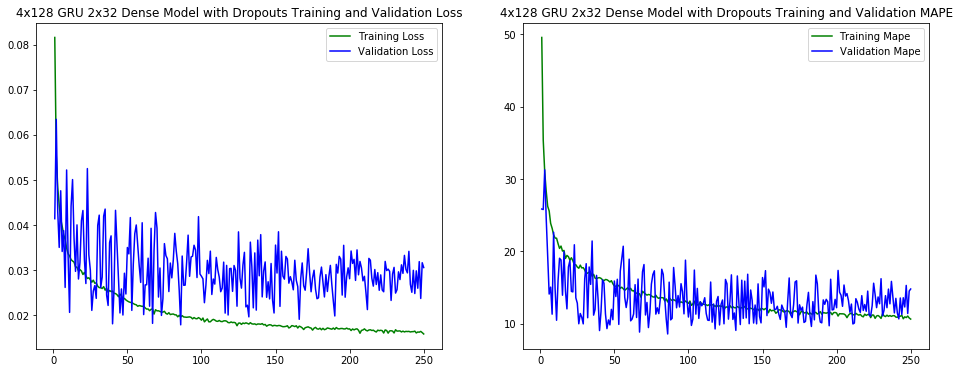

In [56]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [60]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss[-10:]) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.681443
Validation MAE = 2.520015


In [61]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [62]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

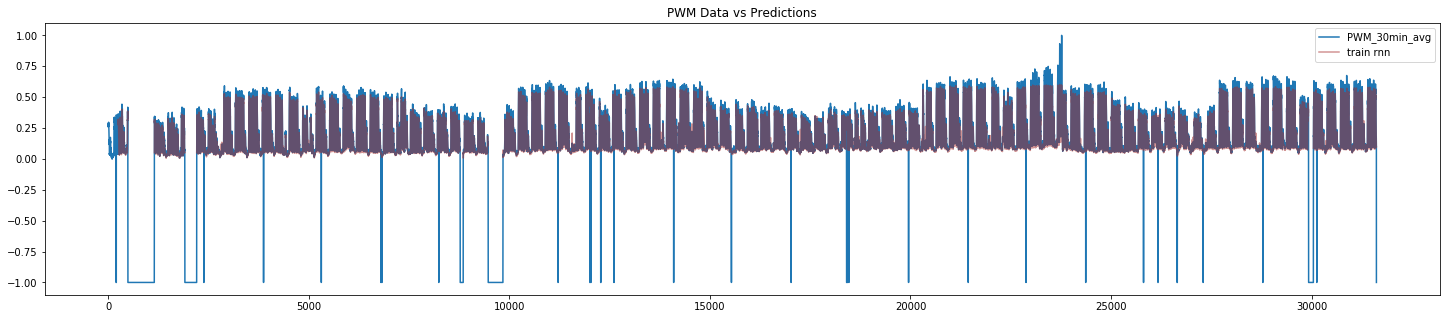

In [63]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

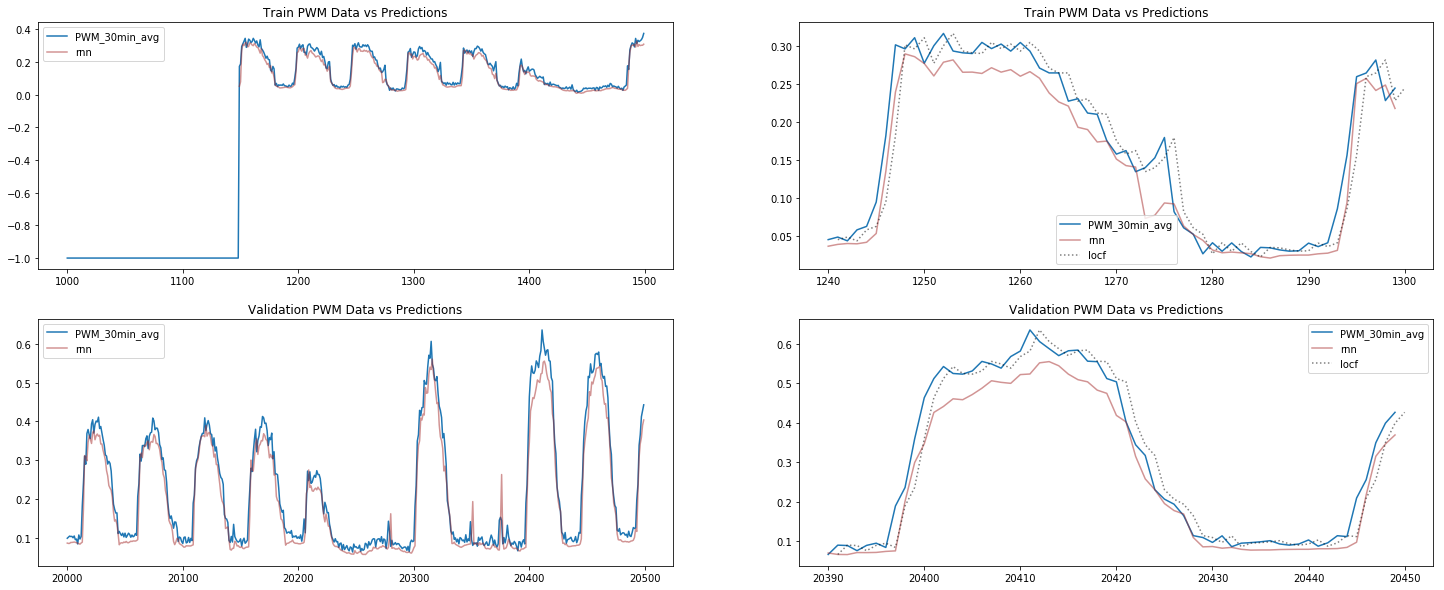

In [64]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [65]:
model.save('base-4x128gru-2x32dense-dropout0104.h5')

In [66]:
with open('base-4x128gru-2x32dense-dropout0104-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Single Layer Dropout (0.2) and Recurrent Dropout (0.2)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout-1x0202-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout-1x0202.h5'))
model.summary()

In [22]:
callbacks = [
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [54]:
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2,
                              callbacks=callbacks)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))


Training start time = 2019-01-29 13:48:37.069840


Epoch 1/50


 - 83s - loss: 0.0132 - mean_absolute_percentage_error: 9.2550 - val_loss: 0.0582 - val_mean_absolute_percentage_error: 25.2833


Epoch 2/50


 - 82s - loss: 0.0133 - mean_absolute_percentage_error: 9.1358 - val_loss: 0.0576 - val_mean_absolute_percentage_error: 24.6033


Epoch 3/50


 - 83s - loss: 0.0132 - mean_absolute_percentage_error: 9.1765 - val_loss: 0.0466 - val_mean_absolute_percentage_error: 18.5366


Epoch 4/50


 - 82s - loss: 0.0133 - mean_absolute_percentage_error: 9.2159 - val_loss: 0.0519 - val_mean_absolute_percentage_error: 19.1926


Epoch 5/50


 - 82s - loss: 0.0131 - mean_absolute_percentage_error: 9.2520 - val_loss: 0.0496 - val_mean_absolute_percentage_error: 19.2709


Epoch 6/50


 - 82s - loss: 0.0131 - mean_absolute_percentage_error: 9.1308 - val_loss: 0.0372 - val_mean_absolute_percentage_error: 15.9808


Epoch 7/50


 - 82s - loss: 0.0133 - mean_absolute_percentage_error: 9.1344 - val_loss: 0.0581 - val_mean_absolute_percentage_error: 22.9957


Epoch 8/50


 - 82s - loss: 0.0129 - mean_absolute_percentage_error: 8.8404 - val_loss: 0.0465 - val_mean_absolute_percentage_error: 18.6928


Epoch 9/50


 - 83s - loss: 0.0129 - mean_absolute_percentage_error: 9.0531 - val_loss: 0.0496 - val_mean_absolute_percentage_error: 18.2417


Epoch 10/50


 - 82s - loss: 0.0129 - mean_absolute_percentage_error: 8.9731 - val_loss: 0.0505 - val_mean_absolute_percentage_error: 21.5967


Epoch 11/50


 - 82s - loss: 0.0127 - mean_absolute_percentage_error: 8.9446 - val_loss: 0.0447 - val_mean_absolute_percentage_error: 19.3404


Epoch 12/50


 - 82s - loss: 0.0126 - mean_absolute_percentage_error: 8.8090 - val_loss: 0.0404 - val_mean_absolute_percentage_error: 14.4590


Epoch 13/50


 - 82s - loss: 0.0128 - mean_absolute_percentage_error: 8.9392 - val_loss: 0.0468 - val_mean_absolute_percentage_error: 18.1618


Epoch 14/50


 - 81s - loss: 0.0127 - mean_absolute_percentage_error: 8.8944 - val_loss: 0.0444 - val_mean_absolute_percentage_error: 17.9197


Epoch 15/50


 - 81s - loss: 0.0125 - mean_absolute_percentage_error: 8.6902 - val_loss: 0.0551 - val_mean_absolute_percentage_error: 24.5185


Epoch 16/50


 - 82s - loss: 0.0124 - mean_absolute_percentage_error: 8.7124 - val_loss: 0.0539 - val_mean_absolute_percentage_error: 21.7857


Epoch 17/50


 - 82s - loss: 0.0128 - mean_absolute_percentage_error: 8.7203 - val_loss: 0.0503 - val_mean_absolute_percentage_error: 19.8905


Epoch 18/50


 - 82s - loss: 0.0123 - mean_absolute_percentage_error: 8.7840 - val_loss: 0.0523 - val_mean_absolute_percentage_error: 22.8063


Epoch 19/50


 - 81s - loss: 0.0123 - mean_absolute_percentage_error: 8.7079 - val_loss: 0.0440 - val_mean_absolute_percentage_error: 17.9189


Epoch 20/50


 - 81s - loss: 0.0124 - mean_absolute_percentage_error: 8.8659 - val_loss: 0.0464 - val_mean_absolute_percentage_error: 17.3484


Epoch 21/50


 - 81s - loss: 0.0127 - mean_absolute_percentage_error: 8.8906 - val_loss: 0.0540 - val_mean_absolute_percentage_error: 21.4984


Epoch 22/50


 - 81s - loss: 0.0124 - mean_absolute_percentage_error: 8.7232 - val_loss: 0.0515 - val_mean_absolute_percentage_error: 22.5548


Epoch 23/50


 - 82s - loss: 0.0123 - mean_absolute_percentage_error: 8.7428 - val_loss: 0.0588 - val_mean_absolute_percentage_error: 23.0583


Epoch 24/50


 - 83s - loss: 0.0124 - mean_absolute_percentage_error: 8.7180 - val_loss: 0.0452 - val_mean_absolute_percentage_error: 17.9362


Epoch 25/50


 - 84s - loss: 0.0123 - mean_absolute_percentage_error: 8.6205 - val_loss: 0.0502 - val_mean_absolute_percentage_error: 20.7776


Epoch 26/50


 - 83s - loss: 0.0120 - mean_absolute_percentage_error: 8.3437 - val_loss: 0.0437 - val_mean_absolute_percentage_error: 17.5512


Epoch 27/50


 - 81s - loss: 0.0120 - mean_absolute_percentage_error: 8.5081 - val_loss: 0.0446 - val_mean_absolute_percentage_error: 16.3718


Epoch 28/50


 - 82s - loss: 0.0122 - mean_absolute_percentage_error: 8.5493 - val_loss: 0.0487 - val_mean_absolute_percentage_error: 21.4644


Epoch 29/50


 - 82s - loss: 0.0120 - mean_absolute_percentage_error: 8.6175 - val_loss: 0.0458 - val_mean_absolute_percentage_error: 16.1475


Epoch 30/50


 - 81s - loss: 0.0121 - mean_absolute_percentage_error: 8.4050 - val_loss: 0.0466 - val_mean_absolute_percentage_error: 20.1159


Epoch 31/50


 - 81s - loss: 0.0119 - mean_absolute_percentage_error: 8.4145 - val_loss: 0.0490 - val_mean_absolute_percentage_error: 21.3659


Epoch 32/50


 - 81s - loss: 0.0116 - mean_absolute_percentage_error: 8.1318 - val_loss: 0.0445 - val_mean_absolute_percentage_error: 16.2941


Epoch 33/50


 - 81s - loss: 0.0119 - mean_absolute_percentage_error: 8.3505 - val_loss: 0.0390 - val_mean_absolute_percentage_error: 16.8748


Epoch 34/50


 - 81s - loss: 0.0117 - mean_absolute_percentage_error: 8.5068 - val_loss: 0.0464 - val_mean_absolute_percentage_error: 17.1552


Epoch 35/50


 - 81s - loss: 0.0119 - mean_absolute_percentage_error: 8.4650 - val_loss: 0.0500 - val_mean_absolute_percentage_error: 20.9821


Epoch 36/50


 - 81s - loss: 0.0115 - mean_absolute_percentage_error: 8.1884 - val_loss: 0.0551 - val_mean_absolute_percentage_error: 24.6035


Epoch 37/50


 - 84s - loss: 0.0114 - mean_absolute_percentage_error: 8.0629 - val_loss: 0.0477 - val_mean_absolute_percentage_error: 18.5852


Epoch 38/50


 - 82s - loss: 0.0115 - mean_absolute_percentage_error: 8.1608 - val_loss: 0.0454 - val_mean_absolute_percentage_error: 17.8034


Epoch 39/50


 - 82s - loss: 0.0114 - mean_absolute_percentage_error: 8.1548 - val_loss: 0.0478 - val_mean_absolute_percentage_error: 19.5080


Epoch 40/50


 - 81s - loss: 0.0116 - mean_absolute_percentage_error: 8.1329 - val_loss: 0.0469 - val_mean_absolute_percentage_error: 18.1335


Epoch 41/50


 - 81s - loss: 0.0115 - mean_absolute_percentage_error: 8.0905 - val_loss: 0.0505 - val_mean_absolute_percentage_error: 20.4866


Epoch 42/50


 - 82s - loss: 0.0116 - mean_absolute_percentage_error: 8.1001 - val_loss: 0.0424 - val_mean_absolute_percentage_error: 15.6043


Epoch 43/50


 - 81s - loss: 0.0114 - mean_absolute_percentage_error: 7.8544 - val_loss: 0.0496 - val_mean_absolute_percentage_error: 19.9455


Epoch 44/50


 - 81s - loss: 0.0115 - mean_absolute_percentage_error: 8.1771 - val_loss: 0.0523 - val_mean_absolute_percentage_error: 20.1214


Epoch 45/50


 - 81s - loss: 0.0115 - mean_absolute_percentage_error: 8.3031 - val_loss: 0.0430 - val_mean_absolute_percentage_error: 17.1097


Epoch 46/50


 - 82s - loss: 0.0113 - mean_absolute_percentage_error: 7.8110 - val_loss: 0.0493 - val_mean_absolute_percentage_error: 19.7424


Epoch 47/50


 - 81s - loss: 0.0114 - mean_absolute_percentage_error: 8.0724 - val_loss: 0.0468 - val_mean_absolute_percentage_error: 17.4272


Epoch 48/50


 - 82s - loss: 0.0113 - mean_absolute_percentage_error: 8.0225 - val_loss: 0.0486 - val_mean_absolute_percentage_error: 19.6063


Epoch 49/50


 - 81s - loss: 0.0112 - mean_absolute_percentage_error: 7.8484 - val_loss: 0.0469 - val_mean_absolute_percentage_error: 20.3528


Epoch 50/50


 - 81s - loss: 0.0112 - mean_absolute_percentage_error: 7.8343 - val_loss: 0.0491 - val_mean_absolute_percentage_error: 20.2903



Training Duration = 1:08:05.936267


In [55]:
# histories = [] # for first training session
histories.append(history.history)

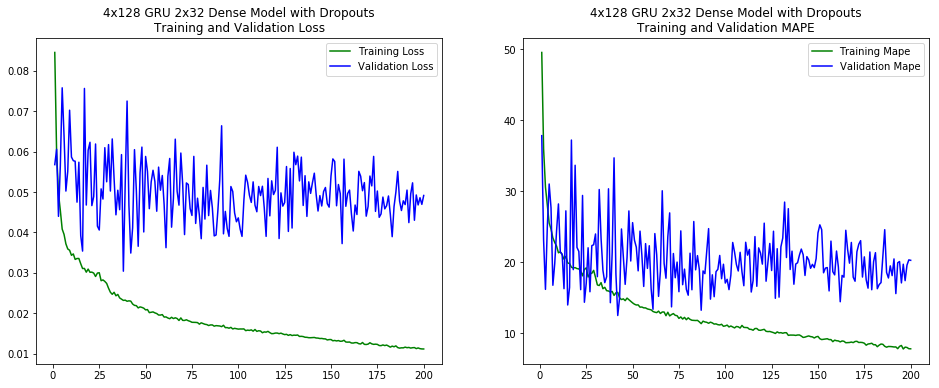

In [56]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [57]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.188571
Validation MAE = 3.235326


In [58]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(29754, 1)

In [59]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

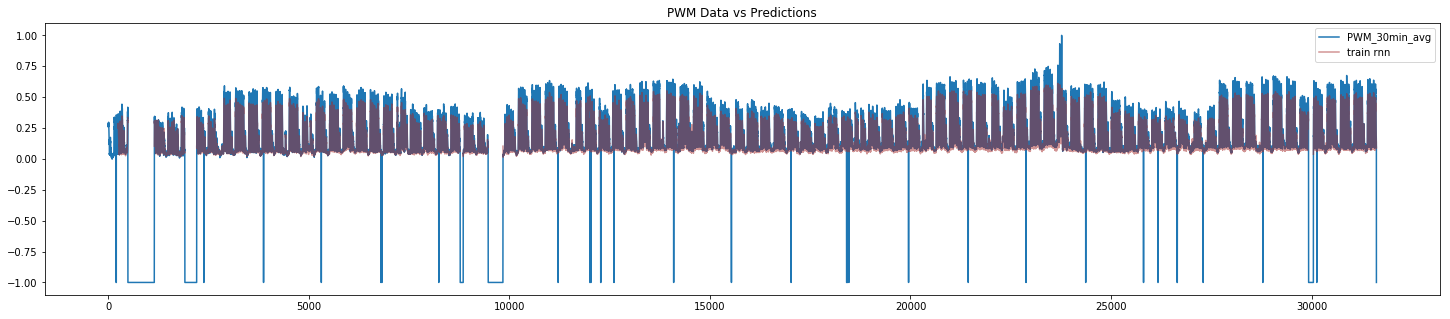

In [60]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

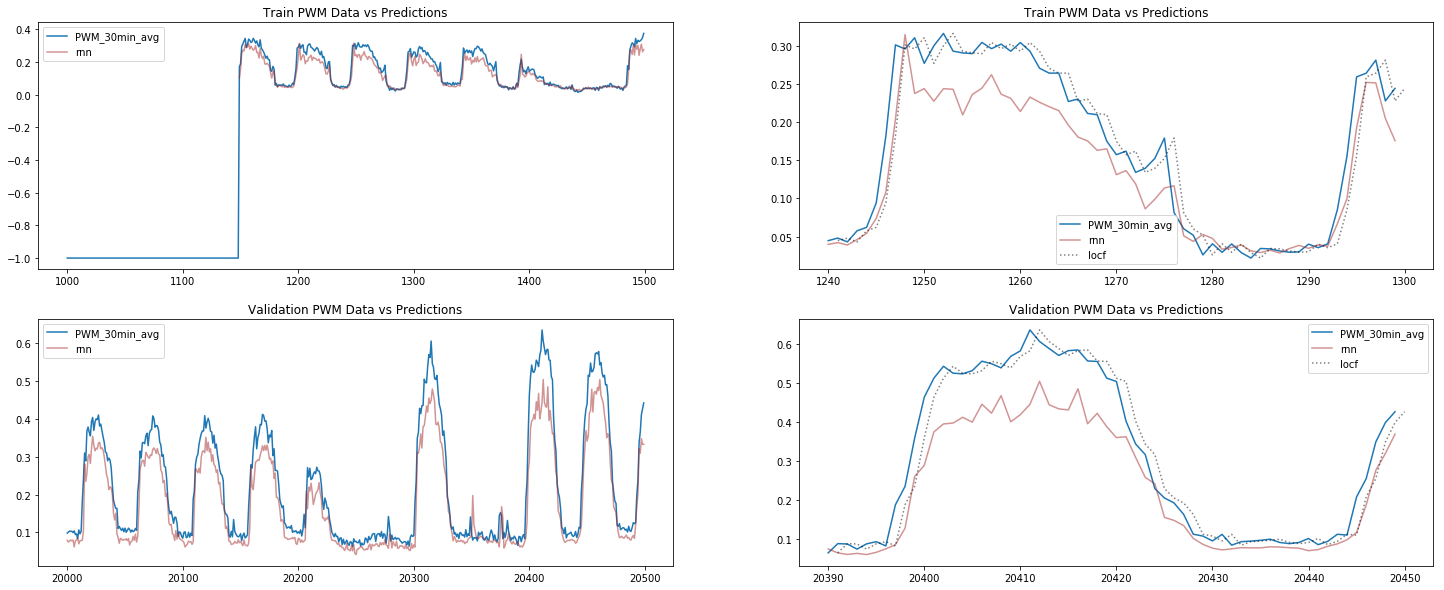

In [61]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [62]:
model.save('base-4x128gru-2x32dense-dropout1x0202.h5')

In [63]:
with open('base-4x128gru-2x32dense-dropout1x0202-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Single Layer Dropout (0.05) and Recurrent Dropout (0.05)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.05, recurrent_dropout=0.05, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout1x005005-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout1x005005.h5'))
model.summary()

In [46]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50


 - 81s - loss: 0.0143 - mean_absolute_percentage_error: 9.8528 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 9.3009


Epoch 2/50


 - 80s - loss: 0.0144 - mean_absolute_percentage_error: 10.2110 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 10.1580


Epoch 3/50


 - 79s - loss: 0.0142 - mean_absolute_percentage_error: 9.8094 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 10.2294


Epoch 4/50


 - 82s - loss: 0.0141 - mean_absolute_percentage_error: 9.7670 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 9.2976


Epoch 5/50


 - 81s - loss: 0.0139 - mean_absolute_percentage_error: 9.6537 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 10.4887


Epoch 6/50


 - 82s - loss: 0.0140 - mean_absolute_percentage_error: 9.8895 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 12.1973


Epoch 7/50


 - 81s - loss: 0.0138 - mean_absolute_percentage_error: 9.4852 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 8.9067


Epoch 8/50


 - 81s - loss: 0.0139 - mean_absolute_percentage_error: 9.8482 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 9.0376


Epoch 9/50


 - 81s - loss: 0.0138 - mean_absolute_percentage_error: 9.6093 - val_loss: 0.0231 - val_mean_absolute_percentage_error: 11.0677


Epoch 10/50


 - 81s - loss: 0.0137 - mean_absolute_percentage_error: 9.5705 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 9.5850


Epoch 11/50


 - 81s - loss: 0.0137 - mean_absolute_percentage_error: 9.6116 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 9.0925


Epoch 12/50


 - 81s - loss: 0.0135 - mean_absolute_percentage_error: 9.4142 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 9.8454


Epoch 13/50


 - 81s - loss: 0.0134 - mean_absolute_percentage_error: 9.5422 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 9.9084


Epoch 14/50


 - 81s - loss: 0.0134 - mean_absolute_percentage_error: 9.4439 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 11.5426


Epoch 15/50


 - 81s - loss: 0.0134 - mean_absolute_percentage_error: 9.4420 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 9.1697


Epoch 16/50


 - 81s - loss: 0.0134 - mean_absolute_percentage_error: 9.2384 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 10.7438


Epoch 17/50


 - 81s - loss: 0.0133 - mean_absolute_percentage_error: 9.3772 - val_loss: 0.0250 - val_mean_absolute_percentage_error: 10.1630


Epoch 18/50


 - 81s - loss: 0.0130 - mean_absolute_percentage_error: 9.1423 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 10.4845


Epoch 19/50


 - 81s - loss: 0.0130 - mean_absolute_percentage_error: 9.3190 - val_loss: 0.0249 - val_mean_absolute_percentage_error: 11.6235


Epoch 20/50


 - 81s - loss: 0.0128 - mean_absolute_percentage_error: 9.0615 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 9.9723


Epoch 21/50


 - 81s - loss: 0.0131 - mean_absolute_percentage_error: 9.2954 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 9.5503


Epoch 22/50


 - 81s - loss: 0.0129 - mean_absolute_percentage_error: 9.2026 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 9.4998


Epoch 23/50


 - 81s - loss: 0.0127 - mean_absolute_percentage_error: 9.0796 - val_loss: 0.0246 - val_mean_absolute_percentage_error: 10.7346


Epoch 24/50


 - 80s - loss: 0.0127 - mean_absolute_percentage_error: 8.9524 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 10.2374


Epoch 25/50


 - 80s - loss: 0.0127 - mean_absolute_percentage_error: 8.9268 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 10.3874


Epoch 26/50


 - 79s - loss: 0.0124 - mean_absolute_percentage_error: 8.9228 - val_loss: 0.0231 - val_mean_absolute_percentage_error: 9.8097


Epoch 27/50


 - 80s - loss: 0.0124 - mean_absolute_percentage_error: 8.8693 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 10.0401


Epoch 28/50


 - 79s - loss: 0.0123 - mean_absolute_percentage_error: 8.7871 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 9.6666


Epoch 29/50


 - 80s - loss: 0.0123 - mean_absolute_percentage_error: 8.7855 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 10.1884


Epoch 30/50


 - 79s - loss: 0.0125 - mean_absolute_percentage_error: 8.9479 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 9.1364


Epoch 31/50


 - 80s - loss: 0.0123 - mean_absolute_percentage_error: 8.7779 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 10.6747


Epoch 32/50


 - 79s - loss: 0.0121 - mean_absolute_percentage_error: 8.5940 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 9.2514


Epoch 33/50


 - 79s - loss: 0.0121 - mean_absolute_percentage_error: 8.7559 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 9.8415


Epoch 34/50


 - 79s - loss: 0.0121 - mean_absolute_percentage_error: 8.7208 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 10.9151


Epoch 35/50


 - 79s - loss: 0.0118 - mean_absolute_percentage_error: 8.6122 - val_loss: 0.0235 - val_mean_absolute_percentage_error: 11.7778


Epoch 36/50


 - 80s - loss: 0.0119 - mean_absolute_percentage_error: 8.5836 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 10.3377


Epoch 37/50


 - 80s - loss: 0.0119 - mean_absolute_percentage_error: 8.3942 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 9.6131


Epoch 38/50


 - 79s - loss: 0.0116 - mean_absolute_percentage_error: 8.3918 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 10.0827


Epoch 39/50


 - 79s - loss: 0.0116 - mean_absolute_percentage_error: 8.3612 - val_loss: 0.0246 - val_mean_absolute_percentage_error: 10.7011


Epoch 40/50


 - 79s - loss: 0.0118 - mean_absolute_percentage_error: 8.3543 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 9.1941


Epoch 41/50


 - 79s - loss: 0.0114 - mean_absolute_percentage_error: 8.2344 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 12.1774


Epoch 42/50


 - 80s - loss: 0.0114 - mean_absolute_percentage_error: 8.1974 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 9.2126


Epoch 43/50


 - 79s - loss: 0.0114 - mean_absolute_percentage_error: 8.3246 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 10.1746


Epoch 44/50


 - 80s - loss: 0.0112 - mean_absolute_percentage_error: 8.0236 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.2633


Epoch 45/50


 - 80s - loss: 0.0114 - mean_absolute_percentage_error: 8.1622 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 11.9807


Epoch 46/50


 - 79s - loss: 0.0112 - mean_absolute_percentage_error: 8.1084 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 12.5009


Epoch 47/50


 - 79s - loss: 0.0111 - mean_absolute_percentage_error: 7.9814 - val_loss: 0.0224 - val_mean_absolute_percentage_error: 9.5267


Epoch 48/50


 - 79s - loss: 0.0112 - mean_absolute_percentage_error: 8.0305 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 9.5481


Epoch 49/50


 - 79s - loss: 0.0109 - mean_absolute_percentage_error: 8.0213 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 9.9816


Epoch 50/50


 - 79s - loss: 0.0108 - mean_absolute_percentage_error: 7.9085 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 11.0818



Training Duration = 1:06:48.093573


In [47]:
# histories = [] # for first training session
histories.append(history.history)

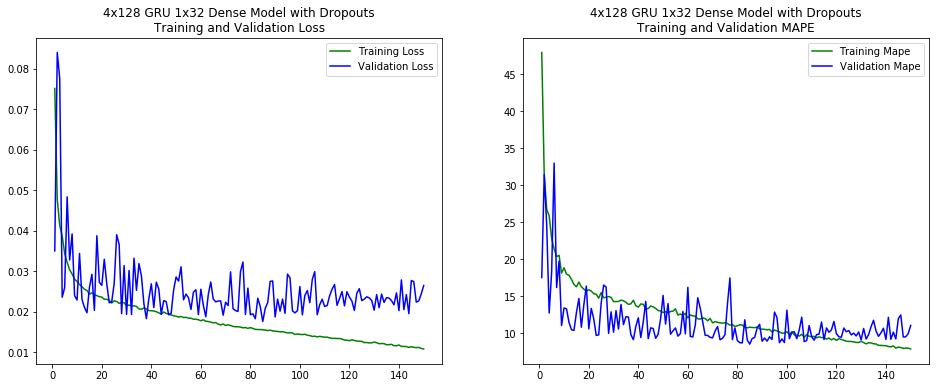

In [48]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 1x32 Dense Model with Dropouts\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 1x32 Dense Model with Dropouts\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [49]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.010789
Validation min loss = 0.017562
Validation min epoch = 84


In [50]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.147767
Validation MAE = 1.868231


In [51]:
as5_train_df['PWM_30min_avg'].min()

gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape


(29754, 1)

In [52]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

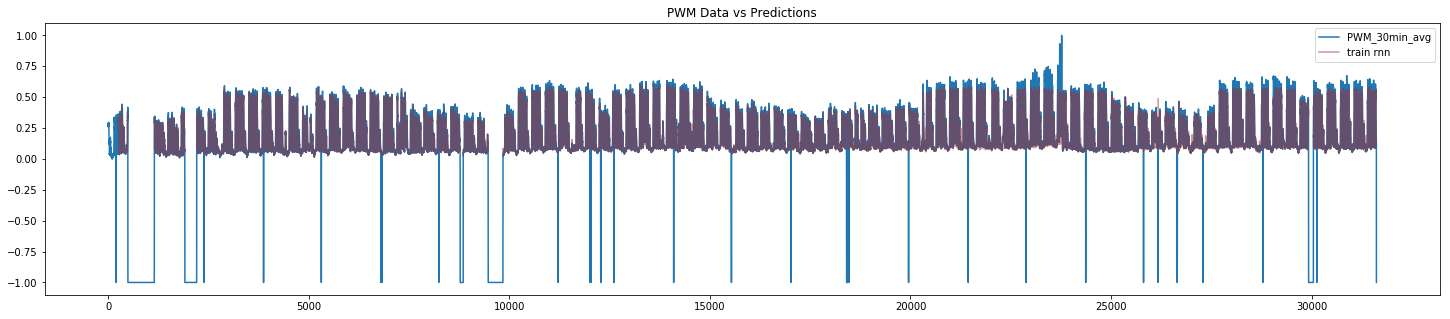

In [53]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

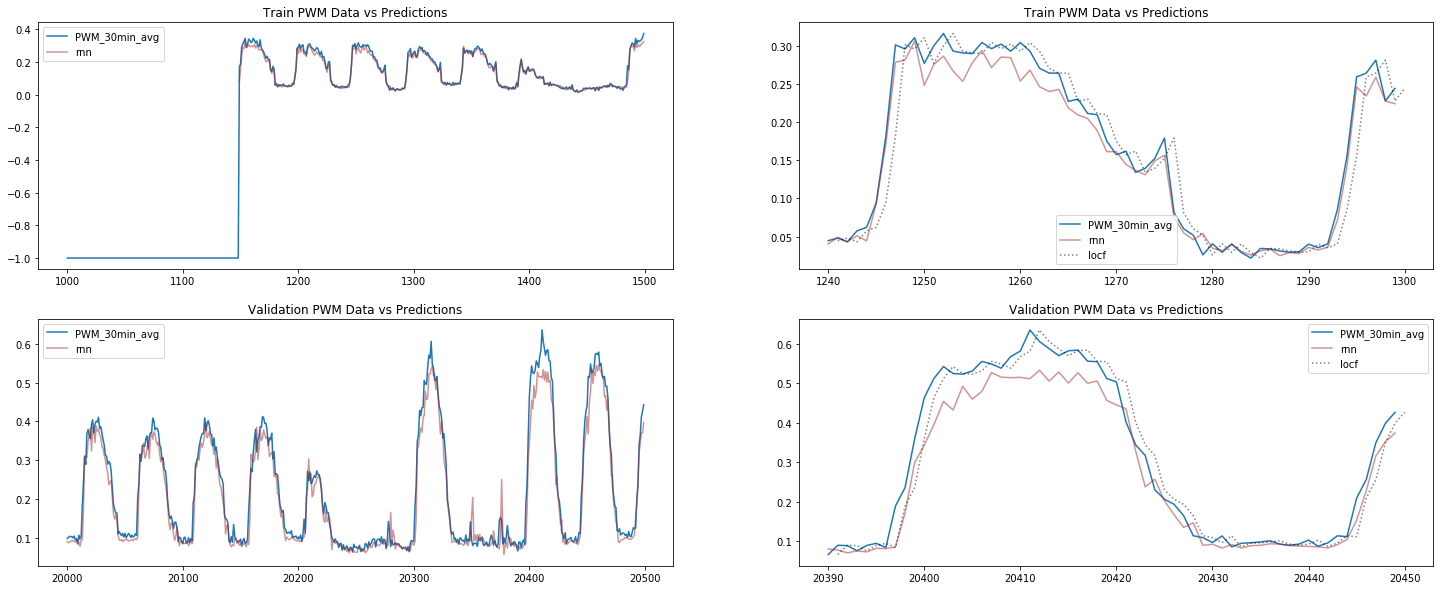

In [54]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [55]:
model.save('base-4x128gru-2x32dense-dropout1x005005.h5')

In [56]:
with open('base-4x128gru-2x32dense-dropout1x005005-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Single Layer Dropout (0.1) and Recurrent Dropout (0.1)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.1, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout1x0101-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout1x0101.h5'))
model.summary()

In [37]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50


 - 82s - loss: 0.0194 - mean_absolute_percentage_error: 13.2275 - val_loss: 0.0341 - val_mean_absolute_percentage_error: 14.0286


Epoch 2/50


 - 82s - loss: 0.0190 - mean_absolute_percentage_error: 13.2755 - val_loss: 0.0311 - val_mean_absolute_percentage_error: 12.7799


Epoch 3/50


 - 82s - loss: 0.0191 - mean_absolute_percentage_error: 13.4652 - val_loss: 0.0370 - val_mean_absolute_percentage_error: 14.1312


Epoch 4/50


 - 81s - loss: 0.0190 - mean_absolute_percentage_error: 13.0681 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 11.8194


Epoch 5/50


 - 81s - loss: 0.0186 - mean_absolute_percentage_error: 12.9410 - val_loss: 0.0327 - val_mean_absolute_percentage_error: 13.7433


Epoch 6/50


 - 81s - loss: 0.0184 - mean_absolute_percentage_error: 12.8257 - val_loss: 0.0368 - val_mean_absolute_percentage_error: 12.7746


Epoch 7/50


 - 82s - loss: 0.0187 - mean_absolute_percentage_error: 12.9840 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 10.8635


Epoch 8/50


 - 81s - loss: 0.0185 - mean_absolute_percentage_error: 12.7908 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 10.7045


Epoch 9/50


 - 80s - loss: 0.0183 - mean_absolute_percentage_error: 12.6396 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 9.4400


Epoch 10/50


 - 80s - loss: 0.0182 - mean_absolute_percentage_error: 12.6047 - val_loss: 0.0359 - val_mean_absolute_percentage_error: 14.0307


Epoch 11/50


 - 81s - loss: 0.0180 - mean_absolute_percentage_error: 12.2971 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 12.0668


Epoch 12/50


 - 80s - loss: 0.0180 - mean_absolute_percentage_error: 12.6355 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 10.9802


Epoch 13/50


 - 80s - loss: 0.0179 - mean_absolute_percentage_error: 12.5056 - val_loss: 0.0381 - val_mean_absolute_percentage_error: 19.0787


Epoch 14/50


 - 80s - loss: 0.0180 - mean_absolute_percentage_error: 12.2324 - val_loss: 0.0250 - val_mean_absolute_percentage_error: 11.9391


Epoch 15/50


 - 80s - loss: 0.0177 - mean_absolute_percentage_error: 12.2386 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 10.4544


Epoch 16/50


 - 80s - loss: 0.0178 - mean_absolute_percentage_error: 12.4264 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 11.2748


Epoch 17/50


 - 80s - loss: 0.0175 - mean_absolute_percentage_error: 12.0689 - val_loss: 0.0362 - val_mean_absolute_percentage_error: 17.4995


Epoch 18/50


 - 80s - loss: 0.0173 - mean_absolute_percentage_error: 11.7601 - val_loss: 0.0294 - val_mean_absolute_percentage_error: 12.4854


Epoch 19/50


 - 80s - loss: 0.0175 - mean_absolute_percentage_error: 11.9644 - val_loss: 0.0245 - val_mean_absolute_percentage_error: 10.3171


Epoch 20/50


 - 81s - loss: 0.0171 - mean_absolute_percentage_error: 11.5692 - val_loss: 0.0288 - val_mean_absolute_percentage_error: 13.1072


Epoch 21/50


 - 81s - loss: 0.0172 - mean_absolute_percentage_error: 11.6349 - val_loss: 0.0372 - val_mean_absolute_percentage_error: 13.8614


Epoch 22/50


 - 80s - loss: 0.0171 - mean_absolute_percentage_error: 11.7508 - val_loss: 0.0317 - val_mean_absolute_percentage_error: 14.3122


Epoch 23/50


 - 81s - loss: 0.0168 - mean_absolute_percentage_error: 11.7875 - val_loss: 0.0348 - val_mean_absolute_percentage_error: 15.7687


Epoch 24/50


 - 81s - loss: 0.0172 - mean_absolute_percentage_error: 11.5714 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 10.5224


Epoch 25/50


 - 81s - loss: 0.0169 - mean_absolute_percentage_error: 11.5988 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 11.1934


Epoch 26/50


 - 80s - loss: 0.0167 - mean_absolute_percentage_error: 11.4606 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 10.7840


Epoch 27/50


 - 80s - loss: 0.0166 - mean_absolute_percentage_error: 11.4209 - val_loss: 0.0305 - val_mean_absolute_percentage_error: 11.2981


Epoch 28/50


 - 80s - loss: 0.0166 - mean_absolute_percentage_error: 11.3769 - val_loss: 0.0363 - val_mean_absolute_percentage_error: 16.7012


Epoch 29/50


 - 80s - loss: 0.0165 - mean_absolute_percentage_error: 11.3861 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 11.1077


Epoch 30/50


 - 80s - loss: 0.0166 - mean_absolute_percentage_error: 11.3644 - val_loss: 0.0191 - val_mean_absolute_percentage_error: 9.0383


Epoch 31/50


 - 80s - loss: 0.0164 - mean_absolute_percentage_error: 11.2747 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 9.4580


Epoch 32/50


 - 80s - loss: 0.0161 - mean_absolute_percentage_error: 11.1866 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 12.1717


Epoch 33/50


 - 80s - loss: 0.0163 - mean_absolute_percentage_error: 11.1898 - val_loss: 0.0313 - val_mean_absolute_percentage_error: 12.4777


Epoch 34/50


 - 80s - loss: 0.0160 - mean_absolute_percentage_error: 10.7272 - val_loss: 0.0241 - val_mean_absolute_percentage_error: 9.5585


Epoch 35/50


 - 79s - loss: 0.0160 - mean_absolute_percentage_error: 10.7568 - val_loss: 0.0332 - val_mean_absolute_percentage_error: 12.2421


Epoch 36/50


 - 80s - loss: 0.0163 - mean_absolute_percentage_error: 11.1459 - val_loss: 0.0303 - val_mean_absolute_percentage_error: 11.7247


Epoch 37/50


 - 80s - loss: 0.0159 - mean_absolute_percentage_error: 10.8235 - val_loss: 0.0305 - val_mean_absolute_percentage_error: 12.4625


Epoch 38/50


 - 80s - loss: 0.0159 - mean_absolute_percentage_error: 10.7989 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 11.0096


Epoch 39/50


 - 80s - loss: 0.0160 - mean_absolute_percentage_error: 10.8283 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 11.2794


Epoch 40/50


 - 80s - loss: 0.0158 - mean_absolute_percentage_error: 10.9196 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 11.0901


Epoch 41/50


 - 80s - loss: 0.0157 - mean_absolute_percentage_error: 10.7257 - val_loss: 0.0311 - val_mean_absolute_percentage_error: 11.4882


Epoch 42/50


 - 80s - loss: 0.0157 - mean_absolute_percentage_error: 10.6580 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 10.3206


Epoch 43/50


 - 81s - loss: 0.0155 - mean_absolute_percentage_error: 10.6539 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 11.3564


Epoch 44/50


 - 80s - loss: 0.0155 - mean_absolute_percentage_error: 10.7607 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 11.8504


Epoch 45/50


 - 79s - loss: 0.0156 - mean_absolute_percentage_error: 10.5493 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 10.9554


Epoch 46/50


 - 79s - loss: 0.0155 - mean_absolute_percentage_error: 10.6951 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 11.3251


Epoch 47/50


 - 80s - loss: 0.0153 - mean_absolute_percentage_error: 10.4682 - val_loss: 0.0398 - val_mean_absolute_percentage_error: 17.1074


Epoch 48/50


 - 80s - loss: 0.0154 - mean_absolute_percentage_error: 10.6895 - val_loss: 0.0363 - val_mean_absolute_percentage_error: 14.3193


Epoch 49/50


 - 80s - loss: 0.0151 - mean_absolute_percentage_error: 10.4959 - val_loss: 0.0364 - val_mean_absolute_percentage_error: 17.0211


Epoch 50/50


 - 80s - loss: 0.0150 - mean_absolute_percentage_error: 10.3703 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 10.6210



Training Duration = 1:06:59.066984


In [42]:
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout1x0101-histories-epch50.pkl'), 'rb') as infile:
    histories = pickle.load(infile)

In [45]:
history

{'val_loss': [0.061000116200654424,
  0.03067047245701579,
  0.04903810459612249,
  0.03169733402545382,
  0.05043051794077064,
  0.06398666957294538,
  0.03404890610482522,
  0.05738003222018037,
  0.03249621294770109,
  0.03278810773013291,
  0.04626913485144226,
  0.030387837939335468,
  0.032512476131855074,
  0.035753384163146947,
  0.028708493718924734,
  0.01942699401774084,
  0.03947301241037712,
  0.038750430958908656,
  0.022499126434700593,
  0.05017554143645021,
  0.04996078637565753,
  0.03578343784255182,
  0.04435450671525984,
  0.032695208273938896,
  0.037244146934573605,
  0.0229985335881441,
  0.03633198882462687,
  0.03504493567041351,
  0.028208602526858563,
  0.04264387452549542,
  0.020971271433224973,
  0.050283169147325245,
  0.03507972669988608,
  0.0321831670629992,
  0.027546937204250135,
  0.04127495333181923,
  0.04045074214410476,
  0.035305870083986966,
  0.03223755294915976,
  0.037204532678179546,
  0.04307517042139746,
  0.035399796402527134,
  0.0340

In [43]:
# histories = [] # for first training session
histories.append(history.history)

AttributeError: 'dict' object has no attribute 'history'

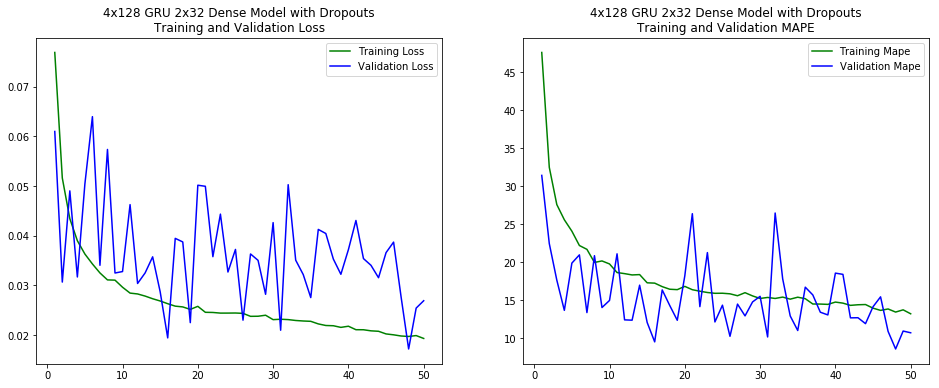

In [44]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [29]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.019316
Validation min loss = 0.017197
Validation min epoch = 47


In [30]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 2.054785
Validation MAE = 1.829380


In [31]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [32]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

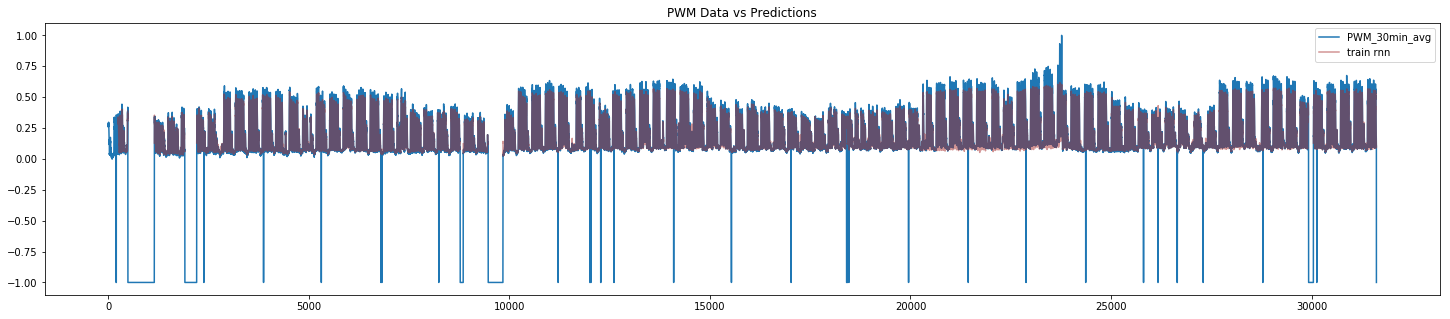

In [33]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

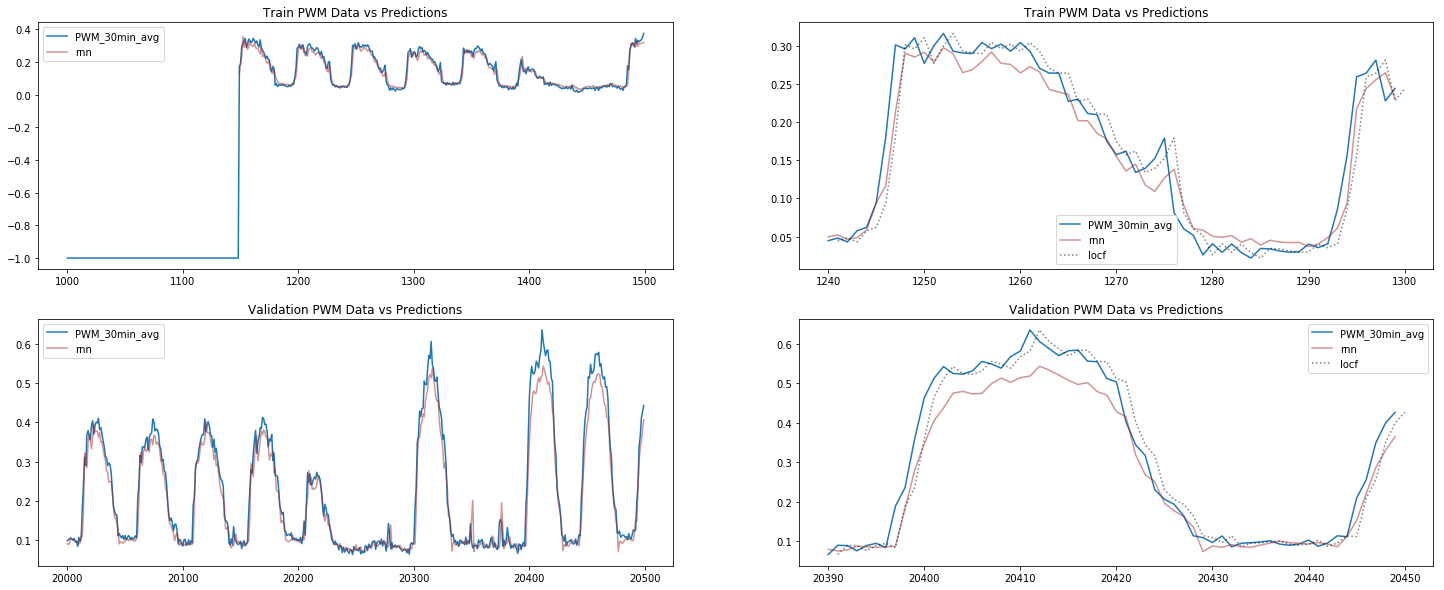

In [34]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [35]:
model.save('base-4x128gru-2x32dense-dropout1x0101.h5')

In [36]:
with open('base-4x128gru-2x32dense-dropout1x0101-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)